<a href="https://colab.research.google.com/github/Stanfording/small_GAN_testing/blob/main/16_cele_small_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Goal:   Just get a small GAN running



Get the preprocessed celebHD data from google drive

In [177]:
# #Download the dataset
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN" -O "proCeleba.zip" && rm -rf /tmp/cookies.txt

# #unzip the dataset
# !unzip "/content/proCeleba.zip"

# #remove unnecessary files
# !rm -rf /content/__MACOSX

## Import libraries

### Install oneflow framework

In [178]:
#!python3 -m pip install -f https://release.oneflow.info oneflow==0.7.0+cu102

In [179]:
#import oneflow as t

In [180]:
from tqdm import tqdm

from torch.autograd import Variable, grad
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import os
import torch as t
import torch.nn as nn
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
from skimage import io
import copy

### Set initial hyperparameters

In [181]:

batch_size = 64

resolution = 16

img_fold_dir_64_reso = f"/content/proCeleba/{resolution}"

iteration = 200

critic = 20          #Train generator 5 times per epoch

eval_size = 25

laten_space = 100

updatD_step = 5

device = t.device('cuda' if t.cuda.is_available() else 'cpu')

log_folder = "log"
!mkdir "log"
!mkdir "log/checkpoint"
!mkdir "log/sample"

mkdir: cannot create directory ‘log’: File exists
mkdir: cannot create directory ‘log/checkpoint’: File exists
mkdir: cannot create directory ‘log/sample’: File exists


### Show me which gpu I am using.

In [182]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-fbc9b77a-d009-7001-6a9e-b01b0c01b631)


### Pre loading the data

In [183]:
# Define a data class for load unclassfied data.
class Get_No_Classes_Img_Dataset(Dataset):
    
    def __init__(self, folder_dir, transform = None):
        self.folder_dir = os.path.join(folder_dir)
        self.transform = transform
        self.image_list = os.listdir(self.folder_dir)
        
    def __len__(self):
        return len(os.listdir(self.folder_dir))
    
    def __getitem__(self, index):
        
        image_name = self.image_list[index]
        
        image_dir = os.path.join(self.folder_dir, image_name)
        
        image = io.imread(image_dir)
        
        if (self.transform != None):
            image = self.transform(image)
        
        return image
    

transform = transforms.ToTensor() #From Batch * Highth * Width * Channel to Batch * Channel * Highth * Width
                                  #Which is what pytorch CNN can work with.

dataset = Get_No_Classes_Img_Dataset(img_fold_dir_64_reso, transform = transform) 
                                                            # datasets[0].shape = (16,16,3)
                                                            # len(datasets) = 28000
total_data_len = len(dataset)
                                                                                            
#datasets_batched = DataLoader(datasets, batch_size = batch_size) #loader is renewed every epoch




```
loader = iter(loader)
print(next(loader).shape) 
```
will output


```
torch.Size([batch_size, 3, resolution, resolution])
```

So data loading is ready.

What's left is keep using 

```
next(loader)
```
to access each batch of data


### Visualize a picture

In [184]:
from IPython.display import Image, display




# Viewing one data sample function:
def showOneImge(img, i, shouldSave):
    
    img = img.squeeze()
    
    img = transforms.ToPILImage()(img)
    
    plt.figure(figsize = (10,10), dpi = 10)
    plt.axis('off')
    
    if shouldSave:
      saveDir = f'{log_folder}/sample/{str(i).zfill(6)}.png'
      plt.imshow(img)
      plt.savefig(saveDir, bbox_inches='tight', pad_inches = 0)
      img = Image(saveDir)
      display(img)
    else:
      deleteDir = f"{log_folder}/sample/Delete.png"
      plt.imshow(img)
      plt.savefig(deleteDir, bbox_inches='tight', pad_inches = 0)
      img = Image(deleteDir)
      display(img)
      !rm "/content/log/sample/Delete.png"
    return 

''' Testing showOneImage'''
# loader = DataLoader(datasets, batch_size = batch_size)

# data = iter(loader)

# oneSample = next(data)[0]

# showOneImge(oneSample, 9999, True)


def showMoreImages(img, num):

  subplot_x = int(num ** (1/2))
  subplot_y = num // subplot_x
  plt.figure(figsize = (2,2))
  for i in range(len(img)):
      aimg = transforms.ToPILImage()(img[i])
      plt.subplot(subplot_x, subplot_y, i+1)
      plt.imshow(aimg)
      plt.axis('off')


-------------------------------------------------

### Now Designing the simple GAN network

In [185]:
"""
Define the generator
"""

class G(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.laten = nn.Sequential(
            nn.Linear(laten_space, 100),
            nn.Linear(100, 500),
            nn.Linear(500, 128 * resolution * resolution))

        self.model = nn.Sequential(
            nn.Conv2d(128, 64, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.Dropout2d(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 3, (3, 3), padding = "same"),
            nn.Sigmoid()
        )
        
        
        
    def forward(self, theInput, batch_size):
        
        x = self.laten(theInput)
        
        x = t.reshape(x, (batch_size, 128, resolution, resolution))
         
        x = self.model(x)
            
            
        return x
    
class D(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.netWork = nn.Sequential(
            nn.Conv2d(3, 64, (3, 3), padding = "same"),
            nn.LeakyReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(64, 128, (3, 3), stride = (3, 3)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 1, (3, 3), stride = (3, 3)),
            nn.Flatten())
        
    def forward(self, theInput):
        
        return self.netWork(theInput)

### Testing the network

In [186]:
"""

Testing the net work:

"""

# oneImg = next(iter(datasets))[0]

# showOneImge(oneImg, 0)

# oneImg = oneImg.expand(1,3,64,64)

# print(oneImg.shape)

# print(oneImg)

# #img into G to test shape

# input_noise_example = t.randn((batch_size, 1, 1, 5))

# a = G()(input_noise_example, batch_size)
# print(a[0])
# showOneImge(a[0], 0)

# b = D()(next(loader))

# print(b.shape)

'\n\nTesting the net work:\n\n'

### Gradient Penalty from wGAN, will test later.

In [187]:
def compute_gradient_penalty(D, real_samples, fake_samples, current_batch_size):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = t.randn((current_batch_size, 1, 1, 1)).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    
    d_interpolates = D(interpolates)
    
    
    grad_x_hat = grad(
            outputs=d_interpolates.sum(), inputs=interpolates, create_graph=True)[0]
    grad_penalty = ((grad_x_hat.view(grad_x_hat.size(0), -1)
                      .norm(2, dim=1) - 1)**2).mean()
    grad_penalty = 10 * grad_penalty
    
    return grad_penalty

### Try FID LOSS

In [188]:
#This is from https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

# example of calculating the frechet inception distance
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
 
# calculate frechet inception distance
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid





### Initializing the generator, discriminator, optimizer, labels, and loss.

In [189]:
generator = G().to(device)
discriminator = D().to(device)
discriminatorReal = D().to(device)

G_optimizer = t.optim.Adam(generator.parameters(), lr = 0.00001)
D_optimizer = t.optim.Adam(discriminator.parameters(), lr = 0.00001)

label_real = t.ones((batch_size, 1)).to(device)
label_fake = t.zeros((batch_size, 1)).to(device)

bceLoss = nn.BCEWithLogitsLoss()

should_train_G = True #True = train d, False = train g

### Train decider

In [190]:
def what_to_train(fake_score, real_score, should_train_G):
  last_should_train_G = should_train_G


  if (fake_score < real_score * score_dif):
    return True

  if last_should_train_G:
    if (fake_score > real_score * (1 - score_dif)):
      return False
    else:
      return True

  return False


  
  



### Start training

Epoch: 1: 100%|██████████| 438/438 [00:18<00:00, 23.49it/s, D_total_loss=-.245, G_loss=-.0371, fake_score=0.0758, real_score=0.454]


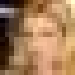

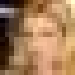

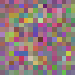

epoch =  1
Epoch [0/200], Step [438/438], d_loss: -0.2455, g_loss: -0.0371, D(x): 0.45, D(G(z)): 0.08


Epoch: 3: 100%|██████████| 438/438 [00:18<00:00, 23.69it/s, D_total_loss=-.914, G_loss=0.0498, fake_score=-.106, real_score=0.937]


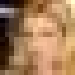

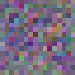

epoch =  3
Epoch [2/200], Step [438/438], d_loss: -0.9142, g_loss: 0.0498, D(x): 0.94, D(G(z)): -0.11


Epoch: 5: 100%|██████████| 438/438 [00:19<00:00, 22.97it/s, D_total_loss=-1.21, G_loss=0.19, fake_score=-.197, real_score=1.07]


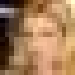

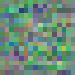

epoch =  5
Epoch [4/200], Step [438/438], d_loss: -1.2072, g_loss: 0.1901, D(x): 1.07, D(G(z)): -0.20


Epoch: 7: 100%|██████████| 438/438 [00:19<00:00, 23.03it/s, D_total_loss=-1.42, G_loss=0.59, fake_score=-.647, real_score=0.879]


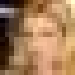

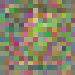

epoch =  7
Epoch [6/200], Step [438/438], d_loss: -1.4229, g_loss: 0.5901, D(x): 0.88, D(G(z)): -0.65


Epoch: 9: 100%|██████████| 438/438 [00:18<00:00, 23.49it/s, D_total_loss=-1.27, G_loss=1.01, fake_score=-1.03, real_score=0.352]


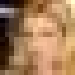

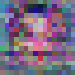

epoch =  9
Epoch [8/200], Step [438/438], d_loss: -1.2745, g_loss: 1.0068, D(x): 0.35, D(G(z)): -1.03


Epoch: 11: 100%|██████████| 438/438 [00:19<00:00, 22.67it/s, D_total_loss=-1.63, G_loss=1.71, fake_score=-1.7, real_score=-.00368]


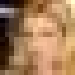

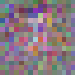

epoch =  11
Epoch [10/200], Step [438/438], d_loss: -1.6269, g_loss: 1.7104, D(x): -0.00, D(G(z)): -1.70


Epoch: 13: 100%|██████████| 438/438 [00:19<00:00, 22.69it/s, D_total_loss=-2.03, G_loss=2.27, fake_score=-2.37, real_score=-.162]


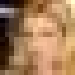

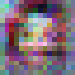

epoch =  13
Epoch [12/200], Step [438/438], d_loss: -2.0347, g_loss: 2.2687, D(x): -0.16, D(G(z)): -2.37


Epoch: 15: 100%|██████████| 438/438 [00:19<00:00, 22.43it/s, D_total_loss=-2.19, G_loss=2.88, fake_score=-2.99, real_score=-.527]


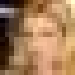

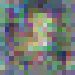

epoch =  15
Epoch [14/200], Step [438/438], d_loss: -2.1870, g_loss: 2.8804, D(x): -0.53, D(G(z)): -2.99


Epoch: 17: 100%|██████████| 438/438 [00:19<00:00, 22.46it/s, D_total_loss=-2.31, G_loss=3.22, fake_score=-3.34, real_score=-.618]


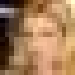

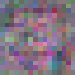

epoch =  17
Epoch [16/200], Step [438/438], d_loss: -2.3084, g_loss: 3.2243, D(x): -0.62, D(G(z)): -3.34


Epoch: 19: 100%|██████████| 438/438 [00:19<00:00, 22.44it/s, D_total_loss=-2, G_loss=2.89, fake_score=-2.86, real_score=-.5]


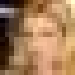

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


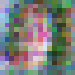

epoch =  19
Epoch [18/200], Step [438/438], d_loss: -1.9974, g_loss: 2.8892, D(x): -0.50, D(G(z)): -2.86


Epoch: 21: 100%|██████████| 438/438 [00:19<00:00, 22.95it/s, D_total_loss=-2.03, G_loss=2.14, fake_score=-2.17, real_score=-.0293]


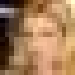

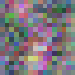

epoch =  21
Epoch [20/200], Step [438/438], d_loss: -2.0304, g_loss: 2.1379, D(x): -0.03, D(G(z)): -2.17


Epoch: 23: 100%|██████████| 438/438 [00:19<00:00, 22.28it/s, D_total_loss=-1.76, G_loss=1.75, fake_score=-1.61, real_score=0.245]


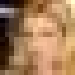

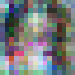

epoch =  23
Epoch [22/200], Step [438/438], d_loss: -1.7555, g_loss: 1.7493, D(x): 0.25, D(G(z)): -1.61


Epoch: 25: 100%|██████████| 438/438 [00:19<00:00, 22.14it/s, D_total_loss=-1.61, G_loss=1.5, fake_score=-1.33, real_score=0.384]


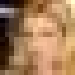

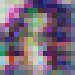

epoch =  25
Epoch [24/200], Step [438/438], d_loss: -1.6106, g_loss: 1.4961, D(x): 0.38, D(G(z)): -1.33


Epoch: 27: 100%|██████████| 438/438 [00:19<00:00, 21.98it/s, D_total_loss=-1.55, G_loss=1.49, fake_score=-1.39, real_score=0.329]


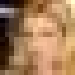

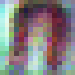

epoch =  27
Epoch [26/200], Step [438/438], d_loss: -1.5535, g_loss: 1.4893, D(x): 0.33, D(G(z)): -1.39


Epoch: 29: 100%|██████████| 438/438 [00:19<00:00, 22.26it/s, D_total_loss=-1.12, G_loss=1.57, fake_score=-1.45, real_score=-.0495]


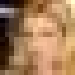

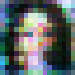

epoch =  29
Epoch [28/200], Step [438/438], d_loss: -1.1185, g_loss: 1.5731, D(x): -0.05, D(G(z)): -1.45


Epoch: 31: 100%|██████████| 438/438 [00:19<00:00, 22.27it/s, D_total_loss=-1.45, G_loss=1.81, fake_score=-1.61, real_score=0.0268]


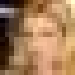

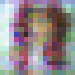

epoch =  31
Epoch [30/200], Step [438/438], d_loss: -1.4494, g_loss: 1.8121, D(x): 0.03, D(G(z)): -1.61


Epoch: 33: 100%|██████████| 438/438 [00:19<00:00, 22.05it/s, D_total_loss=-1.6, G_loss=1.51, fake_score=-1.65, real_score=0.0427]


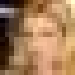

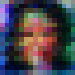

epoch =  33
Epoch [32/200], Step [438/438], d_loss: -1.6044, g_loss: 1.5059, D(x): 0.04, D(G(z)): -1.65


Epoch: 35: 100%|██████████| 438/438 [00:19<00:00, 22.09it/s, D_total_loss=-1.38, G_loss=1.27, fake_score=-1.44, real_score=0.112]


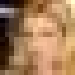

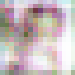

epoch =  35
Epoch [34/200], Step [438/438], d_loss: -1.3846, g_loss: 1.2701, D(x): 0.11, D(G(z)): -1.44


Epoch: 37: 100%|██████████| 438/438 [00:19<00:00, 22.03it/s, D_total_loss=-1.24, G_loss=1.24, fake_score=-1.33, real_score=0.298]


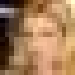

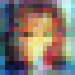

epoch =  37
Epoch [36/200], Step [438/438], d_loss: -1.2450, g_loss: 1.2397, D(x): 0.30, D(G(z)): -1.33


Epoch: 39: 100%|██████████| 438/438 [00:19<00:00, 22.04it/s, D_total_loss=-1.52, G_loss=1.12, fake_score=-1.3, real_score=0.337]


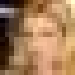

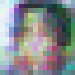

epoch =  39
Epoch [38/200], Step [438/438], d_loss: -1.5163, g_loss: 1.1196, D(x): 0.34, D(G(z)): -1.30


Epoch: 41: 100%|██████████| 438/438 [00:19<00:00, 21.94it/s, D_total_loss=-1.53, G_loss=1, fake_score=-1.3, real_score=0.322]


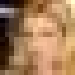

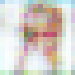

epoch =  41
Epoch [40/200], Step [438/438], d_loss: -1.5310, g_loss: 1.0003, D(x): 0.32, D(G(z)): -1.30


Epoch: 43: 100%|██████████| 438/438 [00:19<00:00, 22.03it/s, D_total_loss=-.861, G_loss=0.744, fake_score=-.945, real_score=0.199]


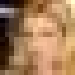

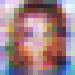

epoch =  43
Epoch [42/200], Step [438/438], d_loss: -0.8611, g_loss: 0.7436, D(x): 0.20, D(G(z)): -0.95


Epoch: 45: 100%|██████████| 438/438 [00:19<00:00, 21.97it/s, D_total_loss=-.853, G_loss=0.883, fake_score=-.76, real_score=0.405]


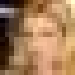

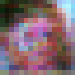

epoch =  45
Epoch [44/200], Step [438/438], d_loss: -0.8526, g_loss: 0.8828, D(x): 0.41, D(G(z)): -0.76


Epoch: 47: 100%|██████████| 438/438 [00:20<00:00, 21.88it/s, D_total_loss=-.214, G_loss=0.836, fake_score=-.49, real_score=0.562]


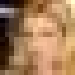

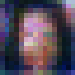

epoch =  47
Epoch [46/200], Step [438/438], d_loss: -0.2140, g_loss: 0.8361, D(x): 0.56, D(G(z)): -0.49


Epoch: 49: 100%|██████████| 438/438 [00:20<00:00, 21.85it/s, D_total_loss=-.754, G_loss=0.838, fake_score=-.491, real_score=0.444]


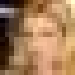

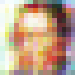

epoch =  49
Epoch [48/200], Step [438/438], d_loss: -0.7543, g_loss: 0.8377, D(x): 0.44, D(G(z)): -0.49


Epoch: 51: 100%|██████████| 438/438 [00:19<00:00, 22.03it/s, D_total_loss=-1.08, G_loss=0.475, fake_score=-.684, real_score=0.463]


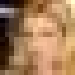

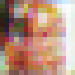

epoch =  51
Epoch [50/200], Step [438/438], d_loss: -1.0759, g_loss: 0.4749, D(x): 0.46, D(G(z)): -0.68


Epoch: 53: 100%|██████████| 438/438 [00:20<00:00, 21.85it/s, D_total_loss=-.733, G_loss=0.311, fake_score=-.501, real_score=0.66]


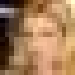

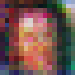

epoch =  53
Epoch [52/200], Step [438/438], d_loss: -0.7329, g_loss: 0.3107, D(x): 0.66, D(G(z)): -0.50


Epoch: 55: 100%|██████████| 438/438 [00:20<00:00, 21.85it/s, D_total_loss=-.775, G_loss=0.479, fake_score=-.332, real_score=0.528]


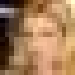

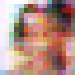

epoch =  55
Epoch [54/200], Step [438/438], d_loss: -0.7749, g_loss: 0.4795, D(x): 0.53, D(G(z)): -0.33


Epoch: 57: 100%|██████████| 438/438 [00:20<00:00, 21.77it/s, D_total_loss=-1.21, G_loss=0.205, fake_score=-.39, real_score=0.917]


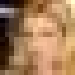

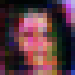

epoch =  57
Epoch [56/200], Step [438/438], d_loss: -1.2055, g_loss: 0.2053, D(x): 0.92, D(G(z)): -0.39


Epoch: 59: 100%|██████████| 438/438 [00:19<00:00, 22.03it/s, D_total_loss=1.01, G_loss=0.483, fake_score=-.279, real_score=0.721]


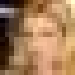

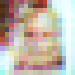

epoch =  59
Epoch [58/200], Step [438/438], d_loss: 1.0057, g_loss: 0.4825, D(x): 0.72, D(G(z)): -0.28


Epoch: 61: 100%|██████████| 438/438 [00:20<00:00, 21.73it/s, D_total_loss=-.982, G_loss=-.0344, fake_score=-.337, real_score=0.982]


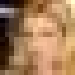

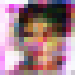

epoch =  61
Epoch [60/200], Step [438/438], d_loss: -0.9818, g_loss: -0.0344, D(x): 0.98, D(G(z)): -0.34


Epoch: 63: 100%|██████████| 438/438 [00:20<00:00, 21.76it/s, D_total_loss=-.662, G_loss=0.172, fake_score=-.196, real_score=0.755]


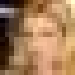

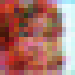

epoch =  63
Epoch [62/200], Step [438/438], d_loss: -0.6616, g_loss: 0.1720, D(x): 0.75, D(G(z)): -0.20


Epoch: 65: 100%|██████████| 438/438 [00:20<00:00, 21.56it/s, D_total_loss=-.48, G_loss=-.0488, fake_score=0.246, real_score=0.78]


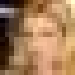

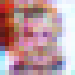

epoch =  65
Epoch [64/200], Step [438/438], d_loss: -0.4796, g_loss: -0.0488, D(x): 0.78, D(G(z)): 0.25


Epoch: 67: 100%|██████████| 438/438 [00:20<00:00, 21.65it/s, D_total_loss=-.307, G_loss=-.196, fake_score=0.186, real_score=0.745]


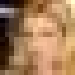

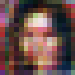

epoch =  67
Epoch [66/200], Step [438/438], d_loss: -0.3068, g_loss: -0.1965, D(x): 0.74, D(G(z)): 0.19


Epoch: 69: 100%|██████████| 438/438 [00:19<00:00, 22.32it/s, D_total_loss=0.816, G_loss=-.366, fake_score=0.28, real_score=1.06]


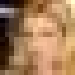

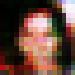

epoch =  69
Epoch [68/200], Step [438/438], d_loss: 0.8158, g_loss: -0.3659, D(x): 1.06, D(G(z)): 0.28


Epoch: 71: 100%|██████████| 438/438 [00:21<00:00, 20.75it/s, D_total_loss=-.741, G_loss=-.174, fake_score=0.202, real_score=1.12]


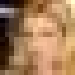

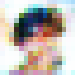

epoch =  71
Epoch [70/200], Step [438/438], d_loss: -0.7407, g_loss: -0.1737, D(x): 1.12, D(G(z)): 0.20


Epoch: 73: 100%|██████████| 438/438 [00:20<00:00, 21.04it/s, D_total_loss=-.635, G_loss=-.374, fake_score=0.309, real_score=1.02]


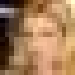

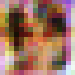

epoch =  73
Epoch [72/200], Step [438/438], d_loss: -0.6346, g_loss: -0.3740, D(x): 1.02, D(G(z)): 0.31


Epoch: 75: 100%|██████████| 438/438 [00:20<00:00, 20.98it/s, D_total_loss=-.532, G_loss=-.161, fake_score=0.186, real_score=0.85]


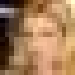

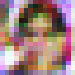

epoch =  75
Epoch [74/200], Step [438/438], d_loss: -0.5321, g_loss: -0.1614, D(x): 0.85, D(G(z)): 0.19


Epoch: 77: 100%|██████████| 438/438 [00:20<00:00, 21.00it/s, D_total_loss=-.0541, G_loss=-.42, fake_score=0.573, real_score=0.925]


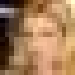

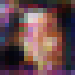

epoch =  77
Epoch [76/200], Step [438/438], d_loss: -0.0541, g_loss: -0.4196, D(x): 0.92, D(G(z)): 0.57


Epoch: 79: 100%|██████████| 438/438 [00:20<00:00, 21.00it/s, D_total_loss=-.716, G_loss=-.425, fake_score=0.267, real_score=1.05]


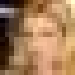

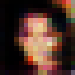

epoch =  79
Epoch [78/200], Step [438/438], d_loss: -0.7163, g_loss: -0.4251, D(x): 1.05, D(G(z)): 0.27


Epoch: 81: 100%|██████████| 438/438 [00:20<00:00, 21.09it/s, D_total_loss=-.469, G_loss=-.225, fake_score=0.269, real_score=0.883]


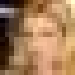

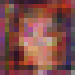

epoch =  81
Epoch [80/200], Step [438/438], d_loss: -0.4687, g_loss: -0.2249, D(x): 0.88, D(G(z)): 0.27


Epoch: 83: 100%|██████████| 438/438 [00:20<00:00, 20.97it/s, D_total_loss=-.227, G_loss=-.47, fake_score=0.377, real_score=0.798]


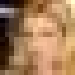

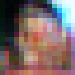

epoch =  83
Epoch [82/200], Step [438/438], d_loss: -0.2272, g_loss: -0.4697, D(x): 0.80, D(G(z)): 0.38


Epoch: 85: 100%|██████████| 438/438 [00:20<00:00, 20.92it/s, D_total_loss=-.291, G_loss=-.33, fake_score=0.499, real_score=0.902]


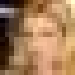

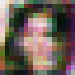

epoch =  85
Epoch [84/200], Step [438/438], d_loss: -0.2914, g_loss: -0.3303, D(x): 0.90, D(G(z)): 0.50


Epoch: 87: 100%|██████████| 438/438 [00:21<00:00, 20.77it/s, D_total_loss=-.176, G_loss=-.639, fake_score=0.387, real_score=0.627]


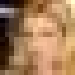

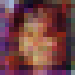

epoch =  87
Epoch [86/200], Step [438/438], d_loss: -0.1755, g_loss: -0.6393, D(x): 0.63, D(G(z)): 0.39


Epoch: 89: 100%|██████████| 438/438 [00:21<00:00, 20.77it/s, D_total_loss=-.0353, G_loss=-.448, fake_score=0.692, real_score=0.843]


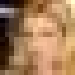

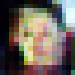

epoch =  89
Epoch [88/200], Step [438/438], d_loss: -0.0353, g_loss: -0.4485, D(x): 0.84, D(G(z)): 0.69


Epoch: 91: 100%|██████████| 438/438 [00:20<00:00, 21.14it/s, D_total_loss=-.0228, G_loss=-.502, fake_score=0.363, real_score=0.714]


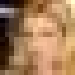

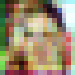

epoch =  91
Epoch [90/200], Step [438/438], d_loss: -0.0228, g_loss: -0.5018, D(x): 0.71, D(G(z)): 0.36


Epoch: 93: 100%|██████████| 438/438 [00:21<00:00, 20.68it/s, D_total_loss=1.36, G_loss=-.579, fake_score=0.521, real_score=0.881]


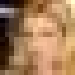

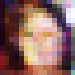

epoch =  93
Epoch [92/200], Step [438/438], d_loss: 1.3562, g_loss: -0.5791, D(x): 0.88, D(G(z)): 0.52


Epoch: 95: 100%|██████████| 438/438 [00:21<00:00, 20.75it/s, D_total_loss=-.0049, G_loss=-.499, fake_score=0.435, real_score=0.899]


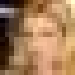

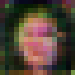

epoch =  95
Epoch [94/200], Step [438/438], d_loss: -0.0049, g_loss: -0.4986, D(x): 0.90, D(G(z)): 0.44


Epoch: 97: 100%|██████████| 438/438 [00:21<00:00, 20.82it/s, D_total_loss=-.407, G_loss=-.363, fake_score=0.31, real_score=0.945]


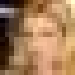

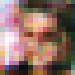

epoch =  97
Epoch [96/200], Step [438/438], d_loss: -0.4066, g_loss: -0.3629, D(x): 0.95, D(G(z)): 0.31


Epoch: 99: 100%|██████████| 438/438 [00:21<00:00, 20.45it/s, D_total_loss=-.249, G_loss=-.466, fake_score=0.61, real_score=1.04]


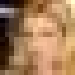

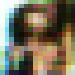

epoch =  99
Epoch [98/200], Step [438/438], d_loss: -0.2492, g_loss: -0.4656, D(x): 1.04, D(G(z)): 0.61


Epoch: 101: 100%|██████████| 438/438 [00:21<00:00, 20.52it/s, D_total_loss=-.424, G_loss=-.762, fake_score=0.741, real_score=1.22]


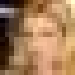

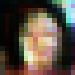

epoch =  101
Epoch [100/200], Step [438/438], d_loss: -0.4243, g_loss: -0.7616, D(x): 1.22, D(G(z)): 0.74


Epoch: 103: 100%|██████████| 438/438 [00:21<00:00, 20.58it/s, D_total_loss=-.243, G_loss=-.594, fake_score=0.732, real_score=1.09]


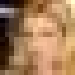

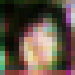

epoch =  103
Epoch [102/200], Step [438/438], d_loss: -0.2431, g_loss: -0.5943, D(x): 1.09, D(G(z)): 0.73


Epoch: 105: 100%|██████████| 438/438 [00:21<00:00, 20.66it/s, D_total_loss=-.16, G_loss=-.589, fake_score=0.539, real_score=0.867]


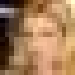

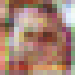

epoch =  105
Epoch [104/200], Step [438/438], d_loss: -0.1598, g_loss: -0.5893, D(x): 0.87, D(G(z)): 0.54


Epoch: 107: 100%|██████████| 438/438 [00:21<00:00, 20.66it/s, D_total_loss=-.221, G_loss=-.816, fake_score=0.831, real_score=1.12]


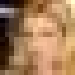

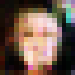

epoch =  107
Epoch [106/200], Step [438/438], d_loss: -0.2210, g_loss: -0.8165, D(x): 1.12, D(G(z)): 0.83


Epoch: 109: 100%|██████████| 438/438 [00:21<00:00, 20.50it/s, D_total_loss=0.0104, G_loss=-.717, fake_score=0.679, real_score=1.01]


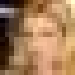

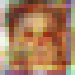

epoch =  109
Epoch [108/200], Step [438/438], d_loss: 0.0104, g_loss: -0.7174, D(x): 1.01, D(G(z)): 0.68


Epoch: 111: 100%|██████████| 438/438 [00:21<00:00, 20.53it/s, D_total_loss=-.151, G_loss=-.593, fake_score=0.68, real_score=0.952]


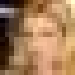

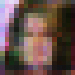

epoch =  111
Epoch [110/200], Step [438/438], d_loss: -0.1513, g_loss: -0.5929, D(x): 0.95, D(G(z)): 0.68


Epoch: 113: 100%|██████████| 438/438 [00:21<00:00, 20.01it/s, D_total_loss=0.0756, G_loss=-.821, fake_score=0.817, real_score=0.897]


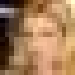

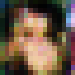

epoch =  113
Epoch [112/200], Step [438/438], d_loss: 0.0756, g_loss: -0.8211, D(x): 0.90, D(G(z)): 0.82


Epoch: 115: 100%|██████████| 438/438 [00:21<00:00, 20.12it/s, D_total_loss=1.73, G_loss=-.796, fake_score=0.742, real_score=1.16]


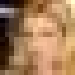

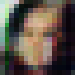

epoch =  115
Epoch [114/200], Step [438/438], d_loss: 1.7291, g_loss: -0.7959, D(x): 1.16, D(G(z)): 0.74


Epoch: 117: 100%|██████████| 438/438 [00:21<00:00, 20.28it/s, D_total_loss=-.266, G_loss=-.728, fake_score=0.914, real_score=1.24]


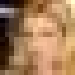

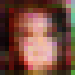

epoch =  117
Epoch [116/200], Step [438/438], d_loss: -0.2656, g_loss: -0.7281, D(x): 1.24, D(G(z)): 0.91


Epoch: 119: 100%|██████████| 438/438 [00:21<00:00, 20.50it/s, D_total_loss=-.292, G_loss=-.841, fake_score=0.926, real_score=1.28]


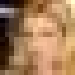

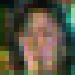

epoch =  119
Epoch [118/200], Step [438/438], d_loss: -0.2919, g_loss: -0.8409, D(x): 1.28, D(G(z)): 0.93


Epoch: 121: 100%|██████████| 438/438 [00:21<00:00, 20.18it/s, D_total_loss=-.44, G_loss=-1.02, fake_score=0.765, real_score=1.29]


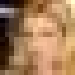

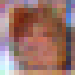

epoch =  121
Epoch [120/200], Step [438/438], d_loss: -0.4397, g_loss: -1.0204, D(x): 1.29, D(G(z)): 0.77


Epoch: 123: 100%|██████████| 438/438 [00:21<00:00, 20.65it/s, D_total_loss=0.00937, G_loss=-.95, fake_score=1.07, real_score=1.1]


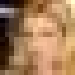

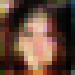

epoch =  123
Epoch [122/200], Step [438/438], d_loss: 0.0094, g_loss: -0.9503, D(x): 1.10, D(G(z)): 1.07


Epoch: 125: 100%|██████████| 438/438 [00:21<00:00, 20.47it/s, D_total_loss=0.495, G_loss=-.991, fake_score=0.831, real_score=1.31]


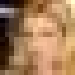

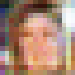

epoch =  125
Epoch [124/200], Step [438/438], d_loss: 0.4950, g_loss: -0.9910, D(x): 1.31, D(G(z)): 0.83


Epoch: 127: 100%|██████████| 438/438 [00:21<00:00, 20.61it/s, D_total_loss=-.253, G_loss=-.915, fake_score=0.858, real_score=1.28]


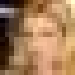

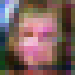

epoch =  127
Epoch [126/200], Step [438/438], d_loss: -0.2526, g_loss: -0.9152, D(x): 1.28, D(G(z)): 0.86


Epoch: 129: 100%|██████████| 438/438 [00:21<00:00, 20.13it/s, D_total_loss=0.38, G_loss=-.931, fake_score=0.992, real_score=1.24]


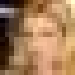

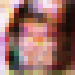

epoch =  129
Epoch [128/200], Step [438/438], d_loss: 0.3796, g_loss: -0.9313, D(x): 1.24, D(G(z)): 0.99


Epoch: 131: 100%|██████████| 438/438 [00:21<00:00, 20.58it/s, D_total_loss=-.371, G_loss=-.809, fake_score=0.771, real_score=1.46]


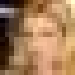

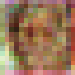

epoch =  131
Epoch [130/200], Step [438/438], d_loss: -0.3714, g_loss: -0.8092, D(x): 1.46, D(G(z)): 0.77


Epoch: 133: 100%|██████████| 438/438 [00:21<00:00, 20.38it/s, D_total_loss=-.558, G_loss=-.996, fake_score=0.941, real_score=1.54]


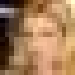

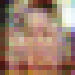

epoch =  133
Epoch [132/200], Step [438/438], d_loss: -0.5582, g_loss: -0.9961, D(x): 1.54, D(G(z)): 0.94


Epoch: 135: 100%|██████████| 438/438 [00:21<00:00, 20.59it/s, D_total_loss=-.362, G_loss=-1.22, fake_score=1.21, real_score=1.61]


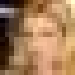

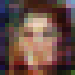

epoch =  135
Epoch [134/200], Step [438/438], d_loss: -0.3618, g_loss: -1.2176, D(x): 1.61, D(G(z)): 1.21


Epoch: 137: 100%|██████████| 438/438 [00:21<00:00, 20.49it/s, D_total_loss=-.292, G_loss=-.854, fake_score=0.978, real_score=1.31]


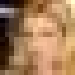

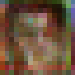

epoch =  137
Epoch [136/200], Step [438/438], d_loss: -0.2921, g_loss: -0.8539, D(x): 1.31, D(G(z)): 0.98


Epoch: 139: 100%|██████████| 438/438 [00:21<00:00, 20.53it/s, D_total_loss=-.65, G_loss=-.948, fake_score=0.815, real_score=1.5]


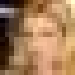

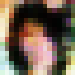

epoch =  139
Epoch [138/200], Step [438/438], d_loss: -0.6497, g_loss: -0.9479, D(x): 1.50, D(G(z)): 0.82


Epoch: 141: 100%|██████████| 438/438 [00:21<00:00, 20.50it/s, D_total_loss=-.234, G_loss=-1.06, fake_score=1.15, real_score=1.54]


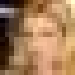

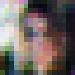

epoch =  141
Epoch [140/200], Step [438/438], d_loss: -0.2342, g_loss: -1.0574, D(x): 1.54, D(G(z)): 1.15


Epoch: 143: 100%|██████████| 438/438 [00:21<00:00, 20.41it/s, D_total_loss=-.346, G_loss=-.851, fake_score=0.756, real_score=1.18]


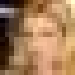

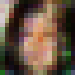

epoch =  143
Epoch [142/200], Step [438/438], d_loss: -0.3459, g_loss: -0.8513, D(x): 1.18, D(G(z)): 0.76


Epoch: 144:  75%|███████▍  | 327/438 [00:16<00:05, 20.99it/s, D_total_loss=-.283, G_loss=-.801, fake_score=0.893, real_score=1.28]

In [ ]:
for i in range(iteration):

    p = tqdm(range(total_data_len // batch_size + 1)) # This is a progress bar run on each epoch
    
    datasets_batched = DataLoader(dataset, batch_size = batch_size)
    
    loader = iter(datasets_batched)

    # real_score = t.Tensor(2)

    # fake_score = t.Tensor(2)

    # g_fake_loss = t.Tensor([2])

    # g_total_loss = 0

    d_step = 0

    for j in p:
        

        batchNum = str(i+1)
        
        #Training the D
        #real data
        real = next(loader).to(device)

        #current_batch size (the last batch is different than others)
        current_batch_size, c, h, w = real.shape
        #labels
        label_real = 0.1 * t.randint(7,10,(current_batch_size,1)).type(t.half)
        label_fake = 0.1 * t.randint(0,3,(current_batch_size,1)).type(t.half)

        real_score = discriminator(real)
        d_real_loss = -t.mean(real_score)
        
        input_noise = t.normal(0, 1, size = (current_batch_size, 1, 1, laten_space)).to(device)
        fake = generator(input_noise, current_batch_size)
        fake_score = discriminator(fake)

        d_fake_loss = t.mean(fake_score)

        gradient_penalty = compute_gradient_penalty(discriminator, real, fake, current_batch_size)
        
        total_loss = d_fake_loss + d_real_loss + gradient_penalty

        generator.zero_grad()
        discriminator.zero_grad()
        total_loss.backward()
        D_optimizer.step()

        d_step += 1

        if d_step == updatD_step:

          discriminatorReal.load_state_dict(discriminator.state_dict().copy())




        if j % critic == 0:
          input_noise = t.normal(0, 1, size = (current_batch_size, 1, 1, laten_space)).to(device)
          fake = generator(input_noise, current_batch_size)
          fake_score = discriminator(fake)
          g_fake_loss = -t.mean(fake_score)
          discriminator.zero_grad()
          generator.zero_grad()
          g_fake_loss.backward()
          G_optimizer.step()
          discriminator.load_state_dict(discriminatorReal.state_dict().copy())
          D_optimizer = t.optim.Adam(discriminator.parameters(), lr = 0.00001)
          d_step = 0
          

        
        mse = "Epoch: " + batchNum
        
        p.set_description(mse)
            
        p.set_postfix(G_loss = g_fake_loss.item(), D_total_loss = total_loss.item(), real_score = real_score.mean().item(), fake_score = fake_score.mean().item())
        
    if i == 0:
        showOneImge(real[0], 99999, True)   
    
    if i % 2 == 0:
      
      showOneImge(real[0], 99999, False)
      showOneImge(fake[0], i, False)
      print("epoch = ", i + 1)  
      print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(i, iteration, j+1, total_data_len // batch_size + 1, total_loss.item(), g_fake_loss.item(), real_score.mean().item(), fake_score.mean().item()))      
      

    if i % 50 == 0:
      t.save(generator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_g.model')
      t.save(discriminator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_d.model')


### Show Result

In [ ]:


#Generated
generator.eval()

with t.no_grad():
  input_noise = t.normal(0, 1, size = (eval_size, 1, 1, laten_space)).to(device)
  generated = generator(input_noise, eval_size)
  showMoreImages(generated, eval_size)

#Real
datasets_batched = DataLoader(dataset, batch_size = eval_size)
loader = iter(datasets_batched)
real = next(loader)
showMoreImages(real, eval_size)

### remove log file when necessarry

In [ ]:
# !rm -rf /content/log/checkpoint

# !mkdir /content/log/checkpoint

# !rm -rf /content/log/sample
# !mkdir /content/log/sample

# from google.colab import files
# files.download('/content/log') 